# SpectrogramMatrix Tutorial

このノートブックでは `gwexpy` の `SpectrogramMatrix` クラスの基本的な使い方を紹介します。

`SpectrogramMatrix` は、複数の `gwpy.spectrogram.Spectrogram` オブジェクトを 3次元 (Batch, Time, Frequency) の行列として効率的に扱うためのクラスです。`numpy.ndarray` を継承しており、高速な数値計算や PyTorch/CuPy との連携が可能です。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.spectrogram import Spectrogram
from gwexpy.spectrogram import SpectrogramList, SpectrogramMatrix
import astropy.units as u

# 乱数シードの固定
np.random.seed(42)

## 1. データの準備

まず、デモ用に複数の `Spectrogram` オブジェクトを作成し、`SpectrogramList` に格納します。
ここでは 10個のチャネル（またはイベント）分のスペクトログラムを生成します。

In [2]:
n_spectrograms = 10
time_points = 100
freq_points = 50
dt = 0.1  # 時間分解能 (s)
df = 1.0  # 周波数分解能 (Hz)

s_list = SpectrogramList()

for i in range(n_spectrograms):
    # ホワイトノイズをベースにする
    data = np.random.normal(0, 1, (time_points, freq_points))
    
    # サンプルとして、チャネルごとに異なる周波数帯に信号を埋め込む
    # data[時間, 周波数]
    start_f = 10 + i * 2
    data[20:80, start_f:start_f+2] += 5.0
    
    spec = Spectrogram(data, dt=dt, df=df, t0=0, f0=0, name=f"Channel_{i}", unit="count")
    s_list.append(spec)

print(f"SpectrogramList created with {len(s_list)} items.")
print(f"Each shape: {s_list[0].shape} (Time, Freq)")

SpectrogramList created with 10 items.
Each shape: (100, 50) (Time, Freq)


## 2. SpectrogramMatrix の作成

`SpectrogramList` の `to_matrix()` メソッドを使用すると、全てのスペクトログラムが一つの `SpectrogramMatrix` にスタックされます。
これにより、形状が `(N, Time, Frequency)` の3次元配列が得られます。

In [3]:
spec_matrix = s_list.to_matrix()

print("Type:", type(spec_matrix))
print("Shape:", spec_matrix.shape)  # (Batch, Time, Freq)

Type: <class 'gwexpy.spectrogram.spectrogram.SpectrogramMatrix'>
Shape: (10, 100, 50)


### 属性へのアクセス
`SpectrogramMatrix` は元のスペクトログラムの時間軸や周波数軸の情報を保持しています。

In [4]:
print("Time axis (first 5):", spec_matrix.times[:5])
print("Freq axis (first 5):", spec_matrix.frequencies[:5])
print("Unit:", spec_matrix.unit)

Time axis (first 5): [0.  0.1 0.2 0.3 0.4] s
Freq axis (first 5): [0. 1. 2. 3. 4.] Hz
Unit: ct


## 3. 数値計算と統計

`SpectrogramMatrix` は `numpy.ndarray` のサブクラスであるため、Numpy の関数をそのまま適用できます。
また、`mean()` などのメソッドも利用可能です。

例えば、全チャネル（バッチ方向）の平均スペクトログラムを計算してみましょう。

In [5]:
# axis=0 (Batch軸) で平均を取る
mean_spectrogram_data = spec_matrix.mean(axis=0)

print("Mean Data Shape:", mean_spectrogram_data.shape)
# 結果は (Time, Freq) の2次元配列になります

Mean Data Shape: (100, 50)


## 4. プロット

`plot()` メソッドを使用すると、データを可視化できます。
3次元データ（Batch, Time, Freq）に対して `plot()` を呼び出すと、デフォルトでは**バッチ方向の平均**がプロットされます。
これは複数のイベントの平均的な特徴を確認するのに便利です。

/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


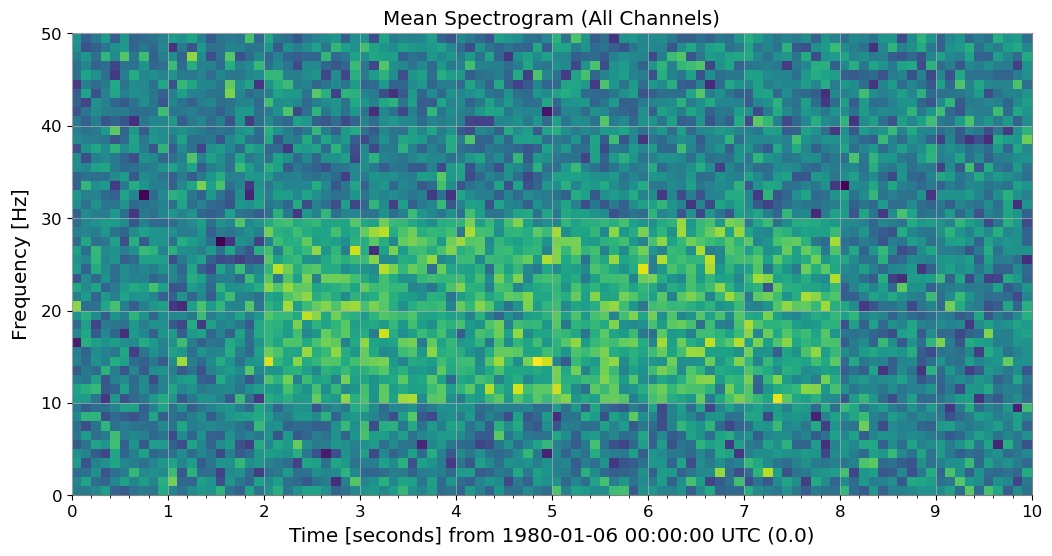

In [6]:
plot = spec_matrix.plot(title="Mean Spectrogram (All Channels)")
plot.show()

特定のチャネルだけをプロットしたい場合は、`monitor` 引数にインデックスを指定します。

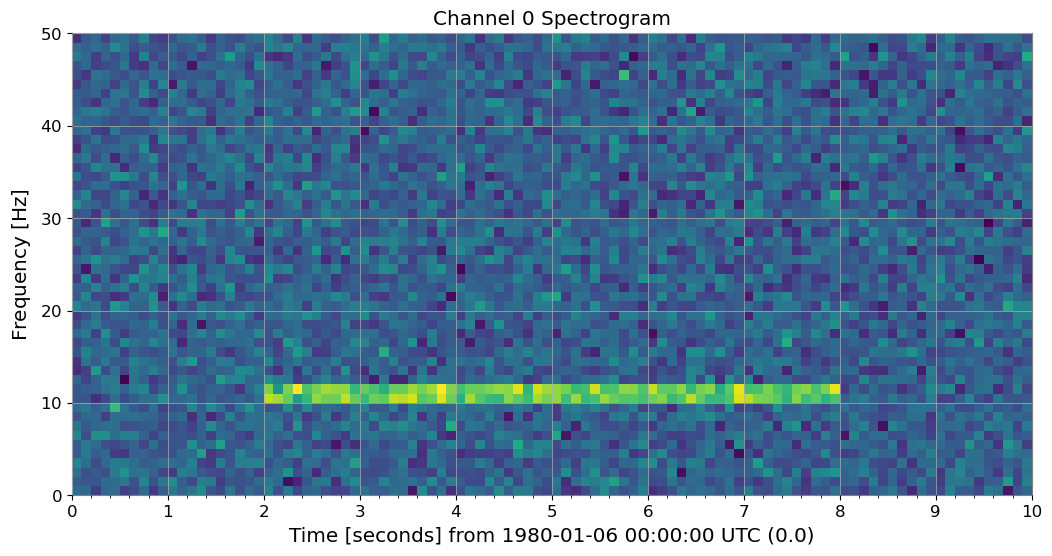

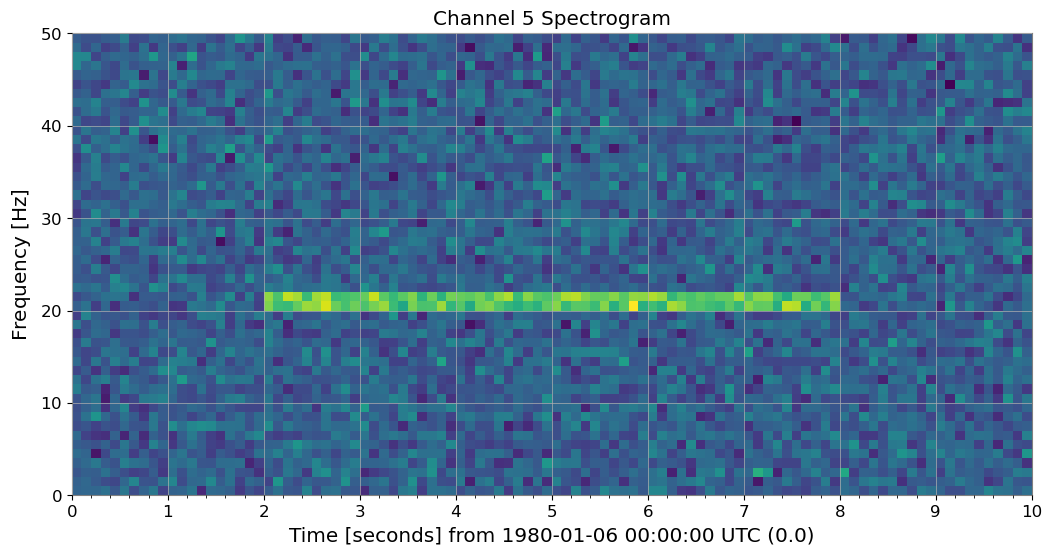

In [7]:
# 最初のチャネル (Channel_0) をプロット
plot0 = spec_matrix.plot(monitor=0, title="Channel 0 Spectrogram")
plot0.show()

# 5番目のチャネル (Channel_5) をプロット
plot5 = spec_matrix.plot(monitor=5, title="Channel 5 Spectrogram")
plot5.show()

## 5. 外部ライブラリとの連携

機械学習やGPU計算のために、PyTorch や CuPy のテンソルへ簡単に変換できます。

In [8]:
# PyTorch Tensor への変換
try:
    import torch
    torch_tensor = spec_matrix.to_torch()
    print("PyTorch Tensor:", type(torch_tensor))
    print("Shape:", torch_tensor.shape)
except ImportError:
    print("PyTorch is not installed.")

# CuPy Array への変換（CUDA環境がある場合）
try:
    # cupy がインストールされていない環境では ImportError になります
    import cupy
    cupy_array = spec_matrix.to_cupy()
    print("CuPy Array:", type(cupy_array))
    print("Shape:", cupy_array.shape)
except ImportError:
    print("CuPy is not installed or GPU is not available.")

PyTorch Tensor: <class 'torch.Tensor'>
Shape: torch.Size([10, 100, 50])
CuPy is not installed or GPU is not available.


## まとめ

- **`SpectrogramMatrix`** は `SpectrogramList.to_matrix()` で作成できます。
- 3次元配列 `(Batch, Time, Freq)` としてデータを保持します。
- `mean()` や `plot()` メソッドで、データの集約や可視化が簡単に行えます。
- `to_torch()` などでディープラーニングフレームワークへデータを渡す際の中間形式としても有用です。